In [94]:
!export PYTHONPATH=$PYTHONPATH:./aihwkit/src/  

# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# PyTorch and ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Main imports
import heyoka as hy
import pykep as pk
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import copy

# Jupyter setup
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting up IBM AI HW Kit

In [95]:
# Imports from PyTorch.
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F
import MultiplyLayer as custom_nn

# Imports from aihwkit.
from aihwkit.nn import AnalogConv1d, AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig, ConstantStepDevice
from aihwkit.simulator.rpu_base import cuda
from aihwkit.simulator.parameters import WeightNoiseType
from aihwkit.simulator.configs import InferenceRPUConfig, WeightModifierType
from aihwkit.simulator.presets import ReRamESPreset
from aihwkit.simulator.presets.devices import ReRamArrayHfO2PresetDevice
from aihwkit.inference import ReRamWan2022NoiseModel, PCMLikeNoiseModel
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.simulator.tiles.base import AnalogTileStateNames, BaseTile, TileModuleBase
from aihwkit.exceptions import TileModuleError

Create hardware profile to simulate on

In [96]:
rram_inference_config = InferenceRPUConfig()
#rram_inference_config.mapping.learn_out_scaling = True
#rram_inference_config.mapping.
    # noise_model=PCMLikeNoiseModel())
#rram_inference_config.modifier.pcm_prob_at_random = 0.20
# rram_inference_config.modifier.type = WeightModifierType.PCM_NOISE
# rram_inference_config.modifier.pcm_prob_at_gmax = 0.00 #0.05 
# rram_inference_config.modifier.pcm_prob_at_reset = 0.00

# rram_inference_config.forward.w_noise_type = WeightNoiseType.ADDITIVE_CONSTANT
# rram_inference_config.forward.w_noise = 0.00 #0.01

# rram_inference_config.forward.inp_res = 1/(2^32)
rram_inference_config.forward.out_res
rram_inference_config.forward.out_bound 

from aihwkit.inference.compensation.drift import GlobalDriftCompensation
# from aihwkit.simulator.configs import WeightModifierType
# rram_inference_config.modifier.type = WeightModifierType.ADD_NORMAL
# #rram_inference_config.modifier.std_dev = 0.1
# rram_inference_config.modifier.pdrop = 0.05
rram_inference_config.drift_compensation = GlobalDriftCompensation()



In [105]:

from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.simulator.parameters.enums import BoundManagementType, NoiseManagementType, WeightClipType, WeightRemapType
from aihwkit.simulator.parameters.io import IOParameters



# Define a single-layer network, using inference/hardware-aware training tile
rpu_config = InferenceRPUConfig()

# rpu_config.pre_post.input_range.learn_input_range = True
# rpu_config.pre_post.input_range.init_from_data = 50
# rpu_config.pre_post.input_range.enable = True
# rpu_config.modifier.pdrop = 0.03  # Drop connect.
# rpu_config.modifier.type = WeightModifierType.ADD_NORMAL  # Fwd/bwd weight noise.
# rpu_config.modifier.std_dev = 0.1
# rpu_config.modifier.rel_to_actual_wmax = True

# Inference noise model.
rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)

# drift compensation
rpu_config.drift_compensation = GlobalDriftCompensation()

rpu_config.backward.is_perfect = True

# Load the dataset
The file nominal_bundle....pk is created in the previous notebook


In [106]:
datset_name="data/training_50000_100_[0.001, 0.001, 0.08, 0.08]_[1.0, 1.0, 1.0, 1.0].pk"
with open(datset_name, "rb") as file:
    data = pkl.load(file)
np.random.shuffle(data)

In [107]:
if torch.cuda.is_available():
    print("PyTorch detected CUDA")
    device = torch.device("cuda:0")
else: 
    print("PyTorch DID NOT detect CUDA")
    device = torch.device("cpu")
print("Training on :", device)

PyTorch detected CUDA
Training on : cuda:0


# Model definition

In [108]:
# A FFNN with continuous activation functions (softplus)
#128 neurons, one less hidden layer in this version
neurons = 256
model = nn.Sequential(
          #custom_nn.Multiply(1),,
          nn.Linear(6,neurons),
          nn.Softplus(),
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,3),
        )
model = model.cuda(device)


# Kaiming_normal initialization method
def initial_weights(m):
    """
    - Initializes weights in each layer according to 'He initialization'.
    Args:
        m   (torch.nn.Linear):         - Neural network layers
    Returns:
        None
    """
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)

# Initialize the weights
_ = model.apply(initial_weights)



display(model)
print("Amount of weights/parameters:", sum([w.numel() for w in model.parameters() if w.requires_grad]))

Sequential(
  (0): Linear(in_features=6, out_features=256, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=256, out_features=3, bias=True)
)

Amount of weights/parameters: 134147


# Convert model to Analog

In [109]:
model = convert_to_analog(model, rpu_config)
model = model.cuda(device)
print(next(model[0].analog_tiles()).tile)


Forward:
	 mv_type:		OnePass
	 inp/out_bound:		1 / 12
	 DAC/ADC:		126 / inf
	 out_noise:		0.06
	 w_noise:		0.02
	 w_noise_type:		1 (AdditiveConstant) 
	 noise_management:	1
	 bound_management [+/-]:Iterative
Backward:
	 using ideal floating point.
Update:
	 using ideal floating point.
RPUCudaPulsed<float>[SimpleRPUDevice](256,6)



# Dataset split and preparation

In [110]:
# We split the whole dataset into training and testing
X_TRAIN, X_VALIDATION, Y_TRAIN, Y_VALIDATION = train_test_split(data.reshape(-1,10)[:,:6], data.reshape(-1,10)[:,6:9], train_size=0.8)
X_TRAIN = torch.tensor(X_TRAIN, device = device)
X_VALIDATION = torch.tensor(X_VALIDATION, device = device)
Y_TRAIN = torch.tensor(Y_TRAIN, device = device)
Y_VALIDATION = torch.tensor(Y_VALIDATION, device = device)

# Optimizer and Loss

In [111]:
# The loss is the cosine of the angle between the predicted and the actual thrust vector
from aihwkit.optim.analog_optimizer import AnalogAdam


cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
# This first loss is directly in degrees
def loss1(ground_truth, prediction):    
    return torch.mean(torch.arccos(cosine_similarity(ground_truth, prediction))) / np.pi * 180
# This is the loss used in the paper with Ekin
def loss2(ground_truth, prediction):    
    return 1 - torch.mean(cosine_similarity(ground_truth, prediction))
loss = loss2

# Setup for the optimizer
learning_rate = 0.5e-4*0.5
optimizer = AnalogSGD(model.parameters(), lr=learning_rate)#weight decay for  
optimizer.regroup_param_groups(model)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True, threshold=0.005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

# Lists used to plot loss over epochs
loss_list = []
loss_val_list = []

# Training loop

In [112]:
n_epochs = 100 #300 minimum
batch_size_train = 4096
batch_size_val = 4096

first = True
start_time = time.time()

# We store the model that suring training obtains the best score on validation
best_model = copy.deepcopy(model)
best_loss = 1e4

print(f'Training batchsize = {batch_size_train}') # Can also be accessed with batchsize = states.shape[0]

for epoch in range(n_epochs):
    if first:
        time_remaining = '-'
    else:
        time_estimate = epoch_time*(n_epochs-epoch+1)
        if time_estimate > 60:
            if time_estimate > 3600:
                time_remaining = str(round(time_estimate/3600,2))+' h'
            else:
                time_remaining = str(round(time_estimate/60,2))+' min'
        else:
            time_remaining = str(round(time_estimate,0))+' s'
        
    first = False
    print(f"Epoch {epoch+1}/{n_epochs}, Current learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}, Time remaining: {'-' if first else time_remaining}")

    start_time_epoch = time.time()
    X_TRAIN, Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN)
    
    # We loop over the entire dataset (ignoring the last incomplete batch)
    for i in tqdm(range(X_TRAIN.shape[0]//batch_size_train)):
        states = X_TRAIN[i*batch_size_train: (i+1)*batch_size_train, :]
        labels = Y_TRAIN[i*batch_size_train: (i+1)*batch_size_train, :]

        # Reset gradients (backward() is cumulative)
        optimizer.zero_grad()
        # Forward pass = prediction
        predictions = model(states.float())

        # Loss
        l = loss(labels, predictions)

        # Backward pass = Gradients (dl/dw)
        l.backward() # Automatically compute the gradient of the loss wrt the weights

        # Update weights
        optimizer.step()
        
    with torch.no_grad():
        # Load random validation batch
        X_VALIDATION, Y_VALIDATION = shuffle(X_TRAIN, Y_TRAIN)
        states_val = X_VALIDATION[:batch_size_val, :]
        labels_val = Y_VALIDATION[:batch_size_val, :]
    
        # Forward pass = prediction
        predictions_val = model(states_val.float())
        
        # Loss
        l_val = loss(labels_val, predictions_val)
        
        if l_val < best_loss:
            best_model = copy.deepcopy(model)
            best_loss = l_val
            print("Updating best model!")
        # Scheduler (reduce learning rate if loss stagnates)
        scheduler.step(l_val)       
    
    # Save values for plots
    loss_list.append(l.item())
    loss_val_list.append(l_val.item())

    print(f'loss = {l:.8f}, loss validation = {l_val:.8f} \n')
    
    epoch_time = (time.time() - start_time_epoch)
    
# Compute excecution time
execution_time = (time.time() - start_time)    
print(f"Total Training Time time: {round(execution_time,2)}s seconds")

Training batchsize = 4096
Epoch 1/100, Current learning rate: 2.5e-05, Time remaining: -


100%|██████████| 3906/3906 [00:26<00:00, 149.97it/s]


Updating best model!
loss = 0.76863905, loss validation = 0.75129350 

Epoch 2/100, Current learning rate: 2.5e-05, Time remaining: 45.74 min


100%|██████████| 3906/3906 [00:25<00:00, 155.59it/s]


Updating best model!
loss = 0.72479267, loss validation = 0.70327921 

Epoch 3/100, Current learning rate: 2.5e-05, Time remaining: 43.68 min


100%|██████████| 3906/3906 [00:25<00:00, 154.52it/s]


Updating best model!
loss = 0.68368044, loss validation = 0.68144500 

Epoch 4/100, Current learning rate: 2.5e-05, Time remaining: 43.65 min


100%|██████████| 3906/3906 [00:24<00:00, 157.10it/s]


Updating best model!
loss = 0.61579435, loss validation = 0.63107271 

Epoch 5/100, Current learning rate: 2.5e-05, Time remaining: 42.48 min


100%|██████████| 3906/3906 [00:26<00:00, 146.52it/s]


Updating best model!
loss = 0.46734219, loss validation = 0.48146941 

Epoch 6/100, Current learning rate: 2.5e-05, Time remaining: 45.05 min


100%|██████████| 3906/3906 [00:26<00:00, 148.51it/s]


Updating best model!
loss = 0.39410337, loss validation = 0.38689395 

Epoch 7/100, Current learning rate: 2.5e-05, Time remaining: 44.07 min


100%|██████████| 3906/3906 [00:25<00:00, 153.86it/s]


Updating best model!
loss = 0.36109893, loss validation = 0.37140352 

Epoch 8/100, Current learning rate: 2.5e-05, Time remaining: 42.01 min


100%|██████████| 3906/3906 [00:25<00:00, 154.27it/s]


Updating best model!
loss = 0.34559899, loss validation = 0.35470458 

Epoch 9/100, Current learning rate: 2.5e-05, Time remaining: 41.34 min


100%|██████████| 3906/3906 [00:25<00:00, 154.71it/s]


Updating best model!
loss = 0.32897370, loss validation = 0.32415976 

Epoch 10/100, Current learning rate: 2.5e-05, Time remaining: 41.01 min


100%|██████████| 3906/3906 [00:25<00:00, 152.97it/s]


loss = 0.32584321, loss validation = 0.33287880 

Epoch 11/100, Current learning rate: 2.5e-05, Time remaining: 40.83 min


100%|██████████| 3906/3906 [00:25<00:00, 156.19it/s]


Updating best model!
loss = 0.32498699, loss validation = 0.31373251 

Epoch 12/100, Current learning rate: 2.5e-05, Time remaining: 39.74 min


100%|██████████| 3906/3906 [00:25<00:00, 154.72it/s]


loss = 0.31875914, loss validation = 0.32119672 

Epoch 13/100, Current learning rate: 2.5e-05, Time remaining: 39.67 min


100%|██████████| 3906/3906 [00:24<00:00, 156.81it/s]


loss = 0.30159897, loss validation = 0.32895612 

Epoch 14/100, Current learning rate: 2.5e-05, Time remaining: 38.64 min


100%|██████████| 3906/3906 [00:26<00:00, 149.41it/s]


loss = 0.30548060, loss validation = 0.31589230 

Epoch 15/100, Current learning rate: 2.5e-05, Time remaining: 39.83 min


100%|██████████| 3906/3906 [00:25<00:00, 151.59it/s]


Updating best model!
loss = 0.30205926, loss validation = 0.31297323 

Epoch 16/100, Current learning rate: 2.5e-05, Time remaining: 39.01 min


100%|██████████| 3906/3906 [00:24<00:00, 157.72it/s]


Updating best model!
loss = 0.30900605, loss validation = 0.30007593 

Epoch 17/100, Current learning rate: 2.5e-05, Time remaining: 37.16 min


100%|██████████| 3906/3906 [00:24<00:00, 159.85it/s]


loss = 0.30522981, loss validation = 0.30144453 

Epoch 18/100, Current learning rate: 2.5e-05, Time remaining: 36.25 min


100%|██████████| 3906/3906 [00:24<00:00, 159.44it/s]


loss = 0.30379611, loss validation = 0.30672272 

Epoch 19/100, Current learning rate: 2.5e-05, Time remaining: 35.96 min


100%|██████████| 3906/3906 [00:25<00:00, 151.75it/s]


Updating best model!
loss = 0.30323227, loss validation = 0.29684070 

Epoch 20/100, Current learning rate: 2.5e-05, Time remaining: 37.58 min


100%|██████████| 3906/3906 [00:24<00:00, 156.35it/s]


loss = 0.29964704, loss validation = 0.29848284 

Epoch 21/100, Current learning rate: 2.5e-05, Time remaining: 35.76 min


100%|██████████| 3906/3906 [00:24<00:00, 157.21it/s]


Updating best model!
loss = 0.29491154, loss validation = 0.29026889 

Epoch 22/100, Current learning rate: 2.5e-05, Time remaining: 35.15 min


100%|██████████| 3906/3906 [00:24<00:00, 158.21it/s]


Updating best model!
loss = 0.29195089, loss validation = 0.28546804 

Epoch 23/100, Current learning rate: 2.5e-05, Time remaining: 34.48 min


100%|██████████| 3906/3906 [00:26<00:00, 147.37it/s]


loss = 0.29738966, loss validation = 0.29521871 

Epoch 24/100, Current learning rate: 2.5e-05, Time remaining: 36.61 min


100%|██████████| 3906/3906 [00:25<00:00, 156.20it/s]


Updating best model!
loss = 0.28759780, loss validation = 0.27985287 

Epoch 25/100, Current learning rate: 2.5e-05, Time remaining: 34.2 min


100%|██████████| 3906/3906 [00:24<00:00, 156.55it/s]


loss = 0.28860885, loss validation = 0.29385268 

Epoch 26/100, Current learning rate: 2.5e-05, Time remaining: 33.31 min


100%|██████████| 3906/3906 [00:25<00:00, 156.21it/s]


loss = 0.28142695, loss validation = 0.28764498 

Epoch 27/100, Current learning rate: 2.5e-05, Time remaining: 33.05 min


100%|██████████| 3906/3906 [00:24<00:00, 158.94it/s]


loss = 0.29178422, loss validation = 0.29093794 

Epoch 28/100, Current learning rate: 2.5e-05, Time remaining: 32.04 min


100%|██████████| 3906/3906 [00:24<00:00, 158.95it/s]


loss = 0.27843590, loss validation = 0.28441832 

Epoch 29/100, Current learning rate: 2.5e-05, Time remaining: 31.6 min


100%|██████████| 3906/3906 [00:24<00:00, 158.00it/s]


Updating best model!
loss = 0.26717193, loss validation = 0.27111356 

Epoch 30/100, Current learning rate: 2.5e-05, Time remaining: 31.43 min


100%|██████████| 3906/3906 [00:25<00:00, 153.34it/s]


loss = 0.27059860, loss validation = 0.27871724 

Epoch 31/100, Current learning rate: 2.5e-05, Time remaining: 31.83 min


100%|██████████| 3906/3906 [00:24<00:00, 156.65it/s]


loss = 0.27314274, loss validation = 0.28132204 

Epoch 32/100, Current learning rate: 2.5e-05, Time remaining: 30.72 min


100%|██████████| 3906/3906 [00:24<00:00, 160.30it/s]


loss = 0.27921932, loss validation = 0.27178796 

Epoch 33/100, Current learning rate: 2.5e-05, Time remaining: 29.6 min


100%|██████████| 3906/3906 [00:23<00:00, 163.58it/s]


Updating best model!
loss = 0.27170972, loss validation = 0.26532464 

Epoch 34/100, Current learning rate: 2.5e-05, Time remaining: 28.68 min


100%|██████████| 3906/3906 [00:24<00:00, 156.46it/s]


Updating best model!
loss = 0.27897608, loss validation = 0.26392377 

Epoch 35/100, Current learning rate: 2.5e-05, Time remaining: 29.83 min


100%|██████████| 3906/3906 [00:24<00:00, 160.12it/s]


Updating best model!
loss = 0.26904576, loss validation = 0.26317893 

Epoch 36/100, Current learning rate: 2.5e-05, Time remaining: 28.59 min


100%|██████████| 3906/3906 [00:24<00:00, 156.58it/s]


loss = 0.26776896, loss validation = 0.27306529 

Epoch 37/100, Current learning rate: 2.5e-05, Time remaining: 28.53 min


100%|██████████| 3906/3906 [00:25<00:00, 153.61it/s]


loss = 0.26499391, loss validation = 0.26506461 

Epoch 38/100, Current learning rate: 2.5e-05, Time remaining: 28.6 min


100%|██████████| 3906/3906 [00:24<00:00, 159.70it/s]


loss = 0.26554312, loss validation = 0.26373469 

Epoch 39/100, Current learning rate: 2.5e-05, Time remaining: 27.12 min


100%|██████████| 3906/3906 [00:25<00:00, 153.25it/s]


loss = 0.26219215, loss validation = 0.26650680 

Epoch 40/100, Current learning rate: 2.5e-05, Time remaining: 27.97 min


100%|██████████| 3906/3906 [00:24<00:00, 158.21it/s]


loss = 0.26309639, loss validation = 0.26666486 

Epoch 41/100, Current learning rate: 2.5e-05, Time remaining: 26.47 min


100%|██████████| 3906/3906 [00:24<00:00, 156.54it/s]


Updating best model!
loss = 0.26443901, loss validation = 0.26203208 

Epoch 42/100, Current learning rate: 2.5e-05, Time remaining: 26.37 min


100%|██████████| 3906/3906 [00:25<00:00, 152.67it/s]


loss = 0.26397944, loss validation = 0.26279059 

Epoch 43/100, Current learning rate: 2.5e-05, Time remaining: 26.63 min


100%|██████████| 3906/3906 [00:25<00:00, 154.99it/s]


loss = 0.26200290, loss validation = 0.26239001 

Epoch 44/100, Current learning rate: 2.5e-05, Time remaining: 25.71 min


100%|██████████| 3906/3906 [00:25<00:00, 154.14it/s]


Updating best model!
loss = 0.26120497, loss validation = 0.26001157 

Epoch 45/100, Current learning rate: 2.5e-05, Time remaining: 25.55 min


100%|██████████| 3906/3906 [00:25<00:00, 152.87it/s]


loss = 0.25470841, loss validation = 0.26670574 

Epoch 46/100, Current learning rate: 2.5e-05, Time remaining: 25.21 min


100%|██████████| 3906/3906 [00:25<00:00, 154.30it/s]


loss = 0.25526336, loss validation = 0.26183589 

Epoch 47/100, Current learning rate: 2.5e-05, Time remaining: 24.51 min


100%|██████████| 3906/3906 [00:24<00:00, 156.96it/s]


loss = 0.25998161, loss validation = 0.26527426 

Epoch 48/100, Current learning rate: 2.5e-05, Time remaining: 23.69 min


100%|██████████| 3906/3906 [00:25<00:00, 156.11it/s]


Updating best model!
loss = 0.25620057, loss validation = 0.25722309 

Epoch 49/100, Current learning rate: 2.5e-05, Time remaining: 23.4 min


100%|██████████| 3906/3906 [00:25<00:00, 152.59it/s]


Updating best model!
loss = 0.26070287, loss validation = 0.25357914 

Epoch 50/100, Current learning rate: 2.5e-05, Time remaining: 23.56 min


100%|██████████| 3906/3906 [00:25<00:00, 150.88it/s]


loss = 0.26202361, loss validation = 0.26622257 

Epoch 51/100, Current learning rate: 2.5e-05, Time remaining: 23.22 min


100%|██████████| 3906/3906 [00:25<00:00, 155.43it/s]


loss = 0.24871033, loss validation = 0.25486670 

Epoch 52/100, Current learning rate: 2.5e-05, Time remaining: 22.12 min


100%|██████████| 3906/3906 [00:24<00:00, 156.28it/s]


Updating best model!
loss = 0.25600377, loss validation = 0.25241391 

Epoch 53/100, Current learning rate: 2.5e-05, Time remaining: 21.63 min


100%|██████████| 3906/3906 [00:24<00:00, 156.26it/s]


Updating best model!
loss = 0.25441865, loss validation = 0.25237963 

Epoch 54/100, Current learning rate: 2.5e-05, Time remaining: 21.23 min


100%|██████████| 3906/3906 [00:25<00:00, 151.95it/s]


loss = 0.25361703, loss validation = 0.25569556 

Epoch 55/100, Current learning rate: 2.5e-05, Time remaining: 21.25 min


100%|██████████| 3906/3906 [00:25<00:00, 155.49it/s]


Updating best model!
loss = 0.24589382, loss validation = 0.24241073 

Epoch 56/100, Current learning rate: 2.5e-05, Time remaining: 20.37 min


100%|██████████| 3906/3906 [00:25<00:00, 153.92it/s]


loss = 0.24578659, loss validation = 0.25456229 

Epoch 57/100, Current learning rate: 2.5e-05, Time remaining: 20.04 min


100%|██████████| 3906/3906 [00:25<00:00, 153.32it/s]


loss = 0.25172607, loss validation = 0.25251496 

Epoch 58/100, Current learning rate: 2.5e-05, Time remaining: 19.67 min


100%|██████████| 3906/3906 [00:25<00:00, 152.14it/s]


loss = 0.25277146, loss validation = 0.25559403 

Epoch 59/100, Current learning rate: 2.5e-05, Time remaining: 19.44 min


100%|██████████| 3906/3906 [00:24<00:00, 157.69it/s]


loss = 0.25029707, loss validation = 0.24930277 

Epoch 60/100, Current learning rate: 2.5e-05, Time remaining: 18.31 min


100%|██████████| 3906/3906 [00:24<00:00, 156.48it/s]


loss = 0.24751744, loss validation = 0.24442796 

Epoch 61/100, Current learning rate: 2.5e-05, Time remaining: 17.98 min


100%|██████████| 3906/3906 [00:24<00:00, 159.16it/s]


loss = 0.24297317, loss validation = 0.25350089 

Epoch 62/100, Current learning rate: 2.5e-05, Time remaining: 17.29 min


100%|██████████| 3906/3906 [00:26<00:00, 148.36it/s]


loss = 0.24322297, loss validation = 0.24707990 

Epoch 63/100, Current learning rate: 2.5e-05, Time remaining: 18.01 min


100%|██████████| 3906/3906 [00:25<00:00, 151.85it/s]


loss = 0.25657778, loss validation = 0.24955650 

Epoch 64/100, Current learning rate: 2.5e-05, Time remaining: 17.14 min


100%|██████████| 3906/3906 [00:24<00:00, 157.31it/s]


loss = 0.25821650, loss validation = 0.24917520 

Epoch 65/100, Current learning rate: 2.5e-05, Time remaining: 16.18 min


100%|██████████| 3906/3906 [00:25<00:00, 155.28it/s]


loss = 0.24761470, loss validation = 0.24872069 

Epoch 66/100, Current learning rate: 2.5e-05, Time remaining: 15.94 min


100%|██████████| 3906/3906 [00:25<00:00, 153.28it/s]


Epoch 00066: reducing learning rate of group 0 to 2.2500e-05.
Epoch 00066: reducing learning rate of group 1 to 2.2500e-05.
Epoch 00066: reducing learning rate of group 2 to 2.2500e-05.
Epoch 00066: reducing learning rate of group 3 to 2.2500e-05.
Epoch 00066: reducing learning rate of group 4 to 2.2500e-05.
loss = 0.24930212, loss validation = 0.24284852 

Epoch 67/100, Current learning rate: 2.25e-05, Time remaining: 15.71 min


100%|██████████| 3906/3906 [00:25<00:00, 151.46it/s]


loss = 0.24594023, loss validation = 0.25797669 

Epoch 68/100, Current learning rate: 2.25e-05, Time remaining: 15.43 min


100%|██████████| 3906/3906 [00:24<00:00, 158.20it/s]


loss = 0.24584644, loss validation = 0.24600372 

Epoch 69/100, Current learning rate: 2.25e-05, Time remaining: 14.33 min


100%|██████████| 3906/3906 [00:25<00:00, 154.50it/s]


loss = 0.24112658, loss validation = 0.24726122 

Epoch 70/100, Current learning rate: 2.25e-05, Time remaining: 14.23 min


100%|██████████| 3906/3906 [00:24<00:00, 157.34it/s]


loss = 0.24754332, loss validation = 0.24943258 

Epoch 71/100, Current learning rate: 2.25e-05, Time remaining: 13.53 min


100%|██████████| 3906/3906 [00:25<00:00, 156.10it/s]


Updating best model!
loss = 0.24326673, loss validation = 0.22672308 

Epoch 72/100, Current learning rate: 2.25e-05, Time remaining: 13.25 min


100%|██████████| 3906/3906 [00:25<00:00, 155.53it/s]


loss = 0.24229918, loss validation = 0.24850439 

Epoch 73/100, Current learning rate: 2.25e-05, Time remaining: 12.84 min


100%|██████████| 3906/3906 [00:25<00:00, 155.64it/s]


loss = 0.23671781, loss validation = 0.24184485 

Epoch 74/100, Current learning rate: 2.25e-05, Time remaining: 12.34 min


100%|██████████| 3906/3906 [00:26<00:00, 150.02it/s]


loss = 0.23716336, loss validation = 0.23688175 

Epoch 75/100, Current learning rate: 2.25e-05, Time remaining: 12.32 min


100%|██████████| 3906/3906 [00:24<00:00, 157.39it/s]


loss = 0.23671761, loss validation = 0.23366159 

Epoch 76/100, Current learning rate: 2.25e-05, Time remaining: 11.33 min


100%|██████████| 3906/3906 [00:25<00:00, 151.26it/s]


loss = 0.23492015, loss validation = 0.24456029 

Epoch 77/100, Current learning rate: 2.25e-05, Time remaining: 11.32 min


100%|██████████| 3906/3906 [00:25<00:00, 151.04it/s]


loss = 0.24650010, loss validation = 0.23839873 

Epoch 78/100, Current learning rate: 2.25e-05, Time remaining: 10.88 min


100%|██████████| 3906/3906 [00:24<00:00, 158.79it/s]


loss = 0.24094505, loss validation = 0.23790168 

Epoch 79/100, Current learning rate: 2.25e-05, Time remaining: 9.94 min


100%|██████████| 3906/3906 [00:25<00:00, 154.45it/s]


loss = 0.24051264, loss validation = 0.22838292 

Epoch 80/100, Current learning rate: 2.25e-05, Time remaining: 9.79 min


100%|██████████| 3906/3906 [00:25<00:00, 151.86it/s]


loss = 0.24796006, loss validation = 0.23502903 

Epoch 81/100, Current learning rate: 2.25e-05, Time remaining: 9.47 min


100%|██████████| 3906/3906 [00:25<00:00, 154.18it/s]


loss = 0.24872397, loss validation = 0.24062272 

Epoch 82/100, Current learning rate: 2.25e-05, Time remaining: 8.92 min


100%|██████████| 3906/3906 [00:25<00:00, 153.65it/s]


Epoch 00082: reducing learning rate of group 0 to 2.0250e-05.
Epoch 00082: reducing learning rate of group 1 to 2.0250e-05.
Epoch 00082: reducing learning rate of group 2 to 2.0250e-05.
Epoch 00082: reducing learning rate of group 3 to 2.0250e-05.
Epoch 00082: reducing learning rate of group 4 to 2.0250e-05.
loss = 0.24710799, loss validation = 0.24097502 

Epoch 83/100, Current learning rate: 2.025e-05, Time remaining: 8.52 min


100%|██████████| 3906/3906 [00:25<00:00, 152.20it/s]


loss = 0.22975965, loss validation = 0.23759435 

Epoch 84/100, Current learning rate: 2.025e-05, Time remaining: 8.14 min


100%|██████████| 3906/3906 [00:25<00:00, 150.58it/s]


loss = 0.24135126, loss validation = 0.23557821 

Epoch 85/100, Current learning rate: 2.025e-05, Time remaining: 7.76 min


100%|██████████| 3906/3906 [00:25<00:00, 151.26it/s]


loss = 0.24014288, loss validation = 0.23095808 

Epoch 86/100, Current learning rate: 2.025e-05, Time remaining: 7.27 min


100%|██████████| 3906/3906 [00:25<00:00, 153.17it/s]


loss = 0.23378533, loss validation = 0.24386363 

Epoch 87/100, Current learning rate: 2.025e-05, Time remaining: 6.72 min


100%|██████████| 3906/3906 [00:25<00:00, 152.78it/s]


loss = 0.23721164, loss validation = 0.24181126 

Epoch 88/100, Current learning rate: 2.025e-05, Time remaining: 6.31 min


100%|██████████| 3906/3906 [00:24<00:00, 156.71it/s]


loss = 0.24366237, loss validation = 0.25056728 

Epoch 89/100, Current learning rate: 2.025e-05, Time remaining: 5.71 min


100%|██████████| 3906/3906 [00:25<00:00, 153.94it/s]


loss = 0.24625775, loss validation = 0.23600914 

Epoch 90/100, Current learning rate: 2.025e-05, Time remaining: 5.37 min


100%|██████████| 3906/3906 [00:24<00:00, 158.46it/s]


loss = 0.24377559, loss validation = 0.24300963 

Epoch 91/100, Current learning rate: 2.025e-05, Time remaining: 4.77 min


100%|██████████| 3906/3906 [00:25<00:00, 154.65it/s]


loss = 0.23725617, loss validation = 0.22997505 

Epoch 92/100, Current learning rate: 2.025e-05, Time remaining: 4.45 min


100%|██████████| 3906/3906 [00:26<00:00, 149.56it/s]


loss = 0.23747410, loss validation = 0.24030475 

Epoch 93/100, Current learning rate: 2.025e-05, Time remaining: 4.13 min


100%|██████████| 3906/3906 [00:26<00:00, 147.57it/s]


Epoch 00093: reducing learning rate of group 0 to 1.8225e-05.
Epoch 00093: reducing learning rate of group 1 to 1.8225e-05.
Epoch 00093: reducing learning rate of group 2 to 1.8225e-05.
Epoch 00093: reducing learning rate of group 3 to 1.8225e-05.
Epoch 00093: reducing learning rate of group 4 to 1.8225e-05.
loss = 0.22687169, loss validation = 0.24062755 

Epoch 94/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 3.71 min


100%|██████████| 3906/3906 [00:26<00:00, 149.68it/s]


loss = 0.22833657, loss validation = 0.24772315 

Epoch 95/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 3.21 min


100%|██████████| 3906/3906 [00:25<00:00, 151.13it/s]


loss = 0.23129785, loss validation = 0.23539134 

Epoch 96/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 2.73 min


100%|██████████| 3906/3906 [00:24<00:00, 157.05it/s]


loss = 0.22711314, loss validation = 0.23873453 

Epoch 97/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 2.19 min


100%|██████████| 3906/3906 [00:25<00:00, 152.26it/s]


Updating best model!
loss = 0.23897087, loss validation = 0.22270340 

Epoch 98/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 1.8 min


100%|██████████| 3906/3906 [00:25<00:00, 155.20it/s]


loss = 0.24270788, loss validation = 0.24129413 

Epoch 99/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 1.33 min


100%|██████████| 3906/3906 [00:25<00:00, 153.12it/s]


loss = 0.23946485, loss validation = 0.24278187 

Epoch 100/100, Current learning rate: 1.8225000000000003e-05, Time remaining: 54.0 s


100%|██████████| 3906/3906 [00:24<00:00, 157.39it/s]


loss = 0.24297106, loss validation = 0.23058540 

Total Training Time time: 2670.39s seconds


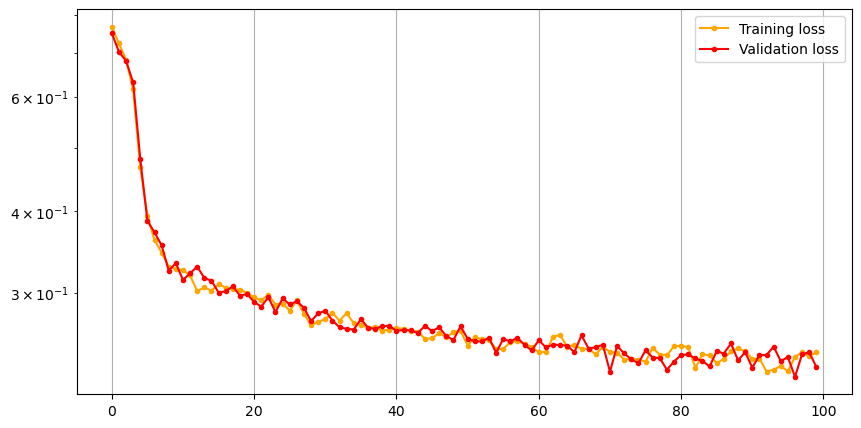

In [113]:
fig, ((ax1)) = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(10)
#ax1.set_title('Loss over epochs')
ax1.grid()
ax1.semilogy(loss_list, 'orange', marker='.',label='Training loss')
ax1.semilogy(loss_val_list, 'red', marker='.', label='Validation loss')
ax1.legend()
plt.show()

In [114]:
# Save model
model_path = f"{datset_name}_{n_epochs}_epochs_4_layers_{neurons}_neurons_{batch_size_train}_batch_size_loss2_analog.mdl"
torch.save(best_model.state_dict(), model_path)

In [115]:
# Save the loss trend
with open("figures/loss_data.pk","wb") as file:
    pkl.dump((loss_list, loss_val_list), file)